In [1]:
from google.colab import files
uploaded = files.upload()

Saving reverb_dataset.py to reverb_dataset.py
Saving utils.py to utils.py


In [2]:
!pip install soundfile
!pip install librosa==0.8.0
!pip install scipy==1.5.2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import os
import sys
import librosa
import librosa.display as display
import soundfile as sf
import os
import sys
import torch
import cv2

import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split

import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from utils import *
from reverb_dataset import ReverbDataset

     |████████████████████████████████| 25.9MB 1.3MB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data

In [ ]:
X_train1 = torch.load('/content/drive/My Drive/data_audio/X_train_1')
X_train2 = torch.load('/content/drive/My Drive/data_audio/X_train_2')
X_train3 = torch.load('/content/drive/My Drive/data_audio/X_train_3')
X_train4 = torch.load('/content/drive/My Drive/data_audio/X_train_4')
y_train1 = torch.load('/content/drive/My Drive/data_audio/y_train_1')
y_train2 = torch.load('/content/drive/My Drive/data_audio/y_train_2')
y_train3 = torch.load('/content/drive/My Drive/data_audio/y_train_3')
y_train4 = torch.load('/content/drive/My Drive/data_audio/y_train_4')

In [ ]:
X = torch.cat((X_train1, X_train2, X_train3, X_train4))
y = torch.cat((y_train1, y_train2, y_train3, y_train4))

In [ ]:
total_dataset = ReverbDataset(X, y)
length_train = int(len(total_dataset)*0.85)
length_val = len(total_dataset) - length_train
lengths = [length_train, length_val]
dataset_train, dataset_val = random_split(total_dataset, lengths)

In [ ]:
print(len(dataset_train))
print(len(dataset_val))

17000
3000


# Model

In [4]:
!git clone http://github.com//milesial/Pytorch-UNet

Cloning into 'Pytorch-UNet'...
remote: Enumerating objects: 352, done.
remote: Total 352 (delta 0), reused 0 (delta 0), pack-reused 352
Receiving objects: 100% (352/352), 47.35 MiB | 20.02 MiB/s, done.
Resolving deltas: 100% (178/178), done.


In [5]:
sys.path.append('Pytorch-UNet')
sys.path.append('Pytorch-UNet/unet')

In [6]:
from unet_parts import *
class UNetRev(nn.Module):
    def __init__(self, n_channels, bilinear=True, confine = False):
        super(UNetRev, self).__init__()
        self.confine = confine
        self.n_channels = n_channels
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, 1)
        self.tanh = nn.Tanh()

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = self.outc(x)
        output = self.tanh(x) if self.confine else x
        return output

In [8]:
def trainer(model, train_loader, val_loader, checkpoints, nEpochs = 100, lr = 1e-3):
  """
  Train model

  model: U-net model on GPU
  train_loader: dataloader containing train examples
  val_loader: dataloader containing validation examples
  checkpoints: list of directories to save the model, train loss and Val loss respectively
  """

  criterion = nn.MSELoss()
  beta1 = 0.5
  beta2 = 0.999
  lr_decay = 0.97
  decay_rate = 2

  optimizer = torch.optim.Adam(model.parameters(), lr, (beta1, beta2))

  train_loss = []
  val_loss = []
  
  model.train()
  for epoch in range(nEpochs):
    temp_train_loss = 0.0
    corrects_train = 0
    for i, (rev_data, clean_data) in enumerate(train_loader):
      rev_data = rev_data.cuda()
      clean_data = clean_data.cuda()

      optimizer.zero_grad()
      output = model(rev_data)
      loss_train = criterion(output, clean_data)
      loss_train.backward()
      optimizer.step()

      temp_train_loss += loss_train.item()/len(train_loader)

    temp_val_loss = 0.0    
    #Validacion
    model.eval()
    with torch.no_grad():
      for i, (rev_data, clean_data) in enumerate(val_loader):
        rev_data = rev_data.cuda()
        clean_data = clean_data.cuda()
        output = model(rev_data)
        loss_val = criterion(output, clean_data)
        temp_val_loss += loss_val.item()/len(val_loader)

    train_loss.append(temp_train_loss)
    val_loss.append(temp_val_loss)

    print('Epoch : {} || Train Loss: {:.3f} || Val Loss: {:.3f}'\
         .format(epoch+1, loss_train.item(), loss_val.item()))
    model.train()
    
    if ((epoch+1)%5 == 0):
      torch.save(model, checkpoints[0])
      torch.save(train_loss, checkpoints[1])
      torch.save(val_loss, checkpoints[2])
      print("saved models")

    if (epoch % decay_rate == 1):
       optimizer.param_groups[0]['lr'] *= lr_decay

  return train_loss, val_loss

In [ ]:
train_loader = DataLoader(dataset_train, batch_size = 16, shuffle = True, num_workers = 4, pin_memory = True)
val_loader = DataLoader(dataset_val, batch_size = 16, shuffle = True, num_workers = 4, pin_memory = True)

In [ ]:
net = UNetRev(n_channels=1, bilinear=False, confine = False)
checkpoints = ['/content/drive/My Drive/data_audio/model_unet1', '/content/drive/My Drive/data_audio/train_loss_unet1', 
               '/content/drive/My Drive/data_audio/val_loss_unet1']
train_loss, val_loss = trainer(net.cuda(), train_loader, val_loader, checkpoints, lr=1e-3, nEpochs = 50)

Epoch : 1 || Train Loss: 29.364 || Val Loss: 35.476
Epoch : 2 || Train Loss: 22.540 || Val Loss: 20.318
Epoch : 3 || Train Loss: 20.088 || Val Loss: 20.290
Epoch : 4 || Train Loss: 21.149 || Val Loss: 18.228
Epoch : 5 || Train Loss: 17.747 || Val Loss: 13.286
saved models
Epoch : 6 || Train Loss: 19.987 || Val Loss: 36.294
Epoch : 7 || Train Loss: 18.654 || Val Loss: 19.377
Epoch : 8 || Train Loss: 21.250 || Val Loss: 16.371
Epoch : 9 || Train Loss: 17.313 || Val Loss: 15.185
Epoch : 10 || Train Loss: 16.706 || Val Loss: 13.277
saved models
Epoch : 11 || Train Loss: 19.302 || Val Loss: 16.863
Epoch : 12 || Train Loss: 14.104 || Val Loss: 12.771
Epoch : 13 || Train Loss: 13.346 || Val Loss: 15.211
Epoch : 14 || Train Loss: 15.538 || Val Loss: 18.169
Epoch : 15 || Train Loss: 12.656 || Val Loss: 15.516
saved models
Epoch : 16 || Train Loss: 15.647 || Val Loss: 14.596
Epoch : 17 || Train Loss: 15.289 || Val Loss: 19.080
Epoch : 18 || Train Loss: 16.177 || Val Loss: 14.800
Epoch : 19 || Tr

In [ ]:
net = UNetRev(n_channels=1, bilinear=False)
checkpoints = ['/content/drive/My Drive/data_audio/model_unet2', '/content/drive/My Drive/data_audio/train_loss_unet2', 
               '/content/drive/My Drive/data_audio/val_loss_unet2']
train_loss, val_loss = trainer(net.cuda(), train_loader, val_loader, checkpoints, lr=1e-3, nEpochs = 50)

Epoch : 1 || Train Loss: 69.557 || Val Loss: 105.014
Epoch : 2 || Train Loss: 22.851 || Val Loss: 24.489
Epoch : 3 || Train Loss: 17.055 || Val Loss: 19.335
Epoch : 4 || Train Loss: 20.234 || Val Loss: 76.205
Epoch : 5 || Train Loss: 17.621 || Val Loss: 20.674
saved models
Epoch : 6 || Train Loss: 14.671 || Val Loss: 15.302
Epoch : 7 || Train Loss: 16.983 || Val Loss: 19.548
Epoch : 8 || Train Loss: 16.332 || Val Loss: 14.598
Epoch : 9 || Train Loss: 17.785 || Val Loss: 16.295
Epoch : 10 || Train Loss: 15.647 || Val Loss: 40.473
saved models
Epoch : 11 || Train Loss: 14.951 || Val Loss: 17.442
Epoch : 12 || Train Loss: 16.718 || Val Loss: 16.945
Epoch : 13 || Train Loss: 14.453 || Val Loss: 15.063
Epoch : 14 || Train Loss: 13.154 || Val Loss: 18.731
Epoch : 15 || Train Loss: 23.309 || Val Loss: 15.476
saved models
Epoch : 16 || Train Loss: 13.268 || Val Loss: 15.564
Epoch : 17 || Train Loss: 17.702 || Val Loss: 17.467
Epoch : 18 || Train Loss: 13.775 || Val Loss: 16.125
Epoch : 19 || T

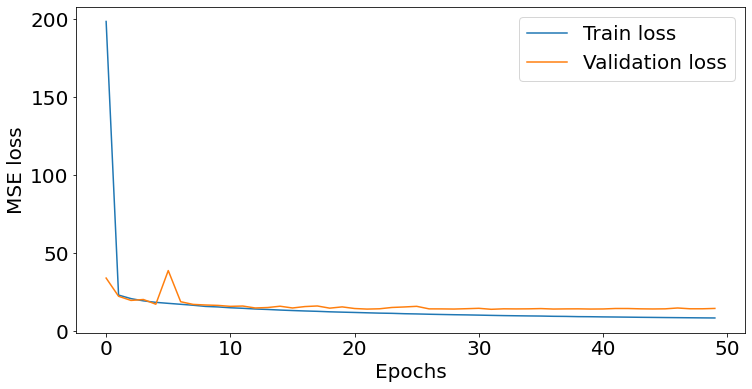

In [ ]:
train_loss = torch.load('/content/drive/My Drive/data_audio/train_loss_unet1')
val_loss = torch.load('/content/drive/My Drive/data_audio/val_loss_unet1')

matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20)
matplotlib.rcParams.update({'font.size': 20})
plt.figure(figsize = (12, 6))
plt.plot(train_loss, label = 'Train loss')
plt.plot(val_loss, label = 'Validation loss')
plt.xlabel('Epochs')
plt.ylabel('MSE loss')
plt.legend()

# Qualitative Evaluation

In [10]:
def evaluate_qualitative(model_G, audio_dirs, num_example, speech_rate=16000):
  """
  net: Unet model on CPU
  audio_dirs: list of directories containing reverberant spectrograms, clean spectrograms,
              reverberant waveforms and clean waveforms respectively
  num_example: example number in data
  speech_rate: sampling rate of speech data  
  """
  
  matplotlib.rc('xtick', labelsize=15) 
  matplotlib.rc('ytick', labelsize=15)
  matplotlib.rcParams.update({'font.size': 15})

  X_test = torch.load(audio_dirs[0])
  y_test = torch.load(audio_dirs[1])
  waves = torch.load(audio_dirs[2])
  waves_target = torch.load(audio_dirs[3])
  dataset_test = ReverbDataset(X_test, y_test)

  original_spec = generate_spec(waves[num_example], speech_rate)
  clean_spec = generate_spec(waves_target[num_example], speech_rate)
  original_size = original_spec.shape

  original_spec = generate_spec(waves[num_example], speech_rate)
  clean_spec = generate_spec(waves_target[num_example], speech_rate)
  original_size = original_spec.shape

  ex = dataset_test.__getitem__(num_example)[0]
  rev_spec = ex[0].numpy()
  example = torch.zeros((1, 1, ex.shape[1], ex.shape[2]))
  example[0, :, :, :] = ex
  model_G.eval()
  derev = model_G(example)

  derev = derev.clone().detach().cpu().numpy()
  derev = derev[0, 0, :, :]
  derev = cv2.resize(derev, dsize = (original_size[1], original_size[0]), interpolation = cv2.INTER_LANCZOS4)

  graph_spec(original_spec)
  graph_spec(clean_spec)
  graph_spec(derev)

In [11]:
model_G = torch.load('/content/drive/My Drive/data_audio/model_unet1', map_location=lambda storage, loc: storage)
dir_list = ['/content/drive/My Drive/data_audio/X_test', '/content/drive/My Drive/data_audio/y_test',
            '/content/drive/My Drive/data_audio/waverev', '/content/drive/My Drive/data_audio/wavetarget']

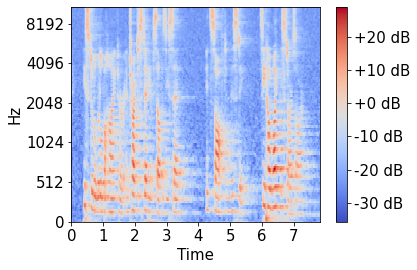

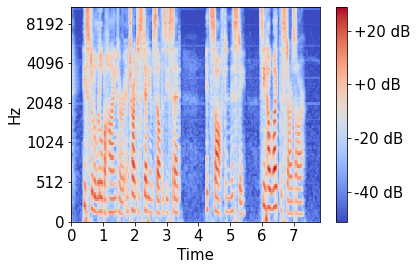

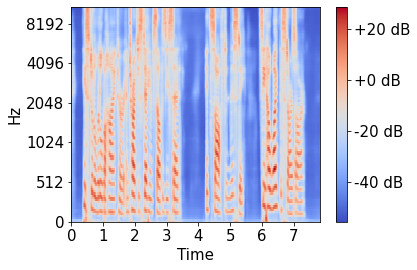

In [12]:
evaluate_qualitative(model_G, dir_list, 100)

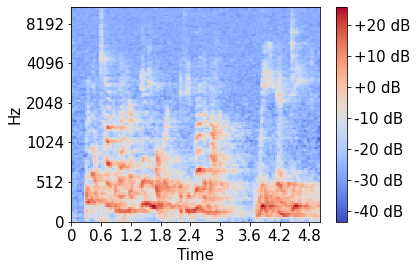

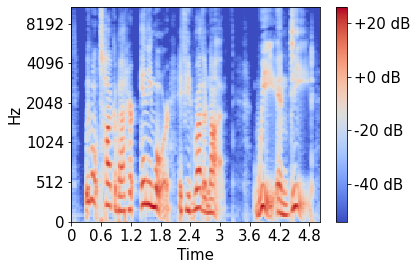

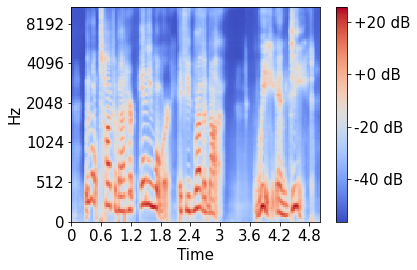

In [ ]:
evaluate_qualitative(model_G, dir_list, 300)

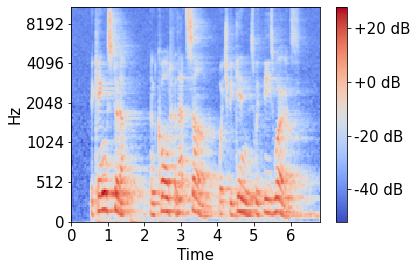

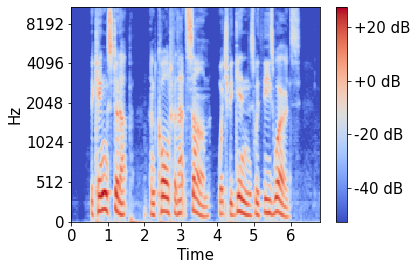

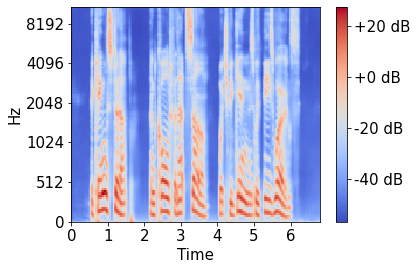

In [ ]:
evaluate_qualitative(model_G, dir_list, 400)

# Quantitative Evaluation

In [ ]:
!pip3 install https://github.com/schmiph2/pysepm/archive/master.zip

     \ 2.0MB 1.3MB/s
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     \ 266kB 299kB/s
     | 71kB 42.2MB/s
     - 67.4MB 1.1MB/s
     |████████████████████████████████| 163kB 4.3MB/s 
  Created wheel for pysepm: filename=pysepm-0.1-cp36-none-any.whl size=24291 sha256=5057acda0fa896146e3b8683fb7296850a8f23a02233307cfe408751d32fa0a1
  Stored in directory: /tmp/pip-ephem-wheel-cache-ghcat5f8/wheels/17/75/23/17712e0da834688ac430e0cf826dd1f7450d0b4873e0269f7c
Successfully built pysepm
  Created wheel for pesq: filename=pesq-0.0.2-cp36-cp36m-linux_x86_64.whl size=161326 sha256=0f828ebdc53893ab413a6bff9512402ec4574bf265754b2d9516e2497a634e93
  Stored in directory: /tmp/pip-ephem-wheel-cache-ghcat5f8/wheels/85/91/09/5ae7677a054a05d49111dc8f3b282e886b3852348384893a32
  Created wheel for pystoi: filename=pystoi-0.3.3-py2.py3-none-any.whl size=7781 sha256=b9563356fa1f569439adcb9685e7631ffa31b03040e7e272a86e62b5c4ee1

In [ ]:
!pip install pystoi
!pip install pypesq
from pysepm import *
from pystoi import stoi
from pypesq import pesq

  Created wheel for pypesq: filename=pypesq-1.2.4-cp36-cp36m-linux_x86_64.whl size=82994 sha256=0257e2338196298b62483344756d9ee1287e1f2bdfe55a8b6c0b61343910675e
  Stored in directory: /root/.cache/pip/wheels/c9/29/a6/ed19583426cffac50b3e75160f894120a49f9bafa585a2edbe
Successfully built pypesq


In [ ]:
def evaluate(net, dataset, path, path_waves, init_example, end_example, speech_rate = 16000, initial = True, normalize_data = False):
  """
  net: U-net model used 
  dataset: reverb_dataset object to extract examples
  path: base directory to save results
  path_waves: directory containing reverb waveforms (not recovered from spectrograms)
  init_example: first example in dataset to be considered
  end_example: last example in dataset to be considered
  speech_rate: sampling rate of speech audios
  initial: True if is the first time executing, False if is not the first time
           if is False the new results are added to the existing results
  normalize_data: True if the net assumed normalized input 
  """

  device = torch.device("cuda:0" if(torch.cuda.is_available()) else "cpu")
  print('Current device: ' + str(device))

  if (initial):
    reverb_pesq_list = []
    reverb_stoi_list = []
    reverb_llr_list = []
    reverb_cd_list = []
    reverb_fwSNRseg_list = []
    reverb_srmr_list = []

    dereverb_pesq_list = []
    dereverb_stoi_list = []
    dereverb_llr_list = []
    dereverb_cd_list = []
    dereverb_fwSNRseg_list = []
    dereverb_srmr_list = []
  
  else:
    reverb_pesq_list = torch.load(path + 'reverb_pesq_unet')
    reverb_stoi_list = torch.load(path + 'reverb_stoi_unet')
    reverb_llr_list = torch.load(path + 'reverb_llr_unet')
    reverb_cd_list = torch.load(path + 'reverb_cd_unet')
    reverb_fwSNRseg_list = torch.load(path + 'reverb_fwSNRseg_unet')
    reverb_srmr_list = torch.load(path + 'reverb_srmr_unet')

    dereverb_pesq_list = torch.load(path + 'dereverb_pesq_unet')
    dereverb_stoi_list = torch.load(path + 'dereverb_stoi_unet')
    dereverb_llr_list = torch.load(path + 'dereverb_llr_unet')
    dereverb_cd_list = torch.load(path + 'dereverb_cd_unet')
    dereverb_fwSNRseg_list = torch.load(path + 'dereverb_fwSNRseg_unet')
    dereverb_srmr_list = torch.load(path + 'dereverb_srmr_unet')
  
  waves = torch.load(path_waves)
  net.eval()
  for i in range(init_example, end_example):
    print("Processing Example n°{}".format(i+1))
    real_spec = generate_spec(waves[i], speech_rate)
    rev_spec, clean_spec = dataset.__getitem__(i)
    clean_spec = clean_spec[0, :, :]
    net_input = torch.zeros((1, 1, rev_spec.shape[1], rev_spec.shape[2]))

    if normalize_data:
      norm_example, norm_stats_rev = linear_scaler(rev_spec[0, :, :].numpy())
      net_input[0, 0, :, :] = torch.tensor(norm_example)
      net_response = net(net_input.to(device))
      net_response = net_response.clone().detach().cpu().numpy() if torch.cuda.is_available() else net_response.clone().detach().numpy()
      net_response = (net_response-norm_stats_rev[1])/norm_stats_rev[0]


    else:
      net_input[0, :, :, :] = rev_spec
      net_response = net(net_input.to(device))
      net_response = net_response.clone().detach().cpu().numpy() if torch.cuda.is_available() else net_response.clone().detach().numpy()
  
    
    try:
      net_response = net_response[0, 0, :, :]
      recon_spec = cv2.resize(net_response, dsize = (real_spec.shape[1], real_spec.shape[0]), interpolation = cv2.INTER_LANCZOS4)
      clean_spec = cv2.resize(clean_spec.numpy(), dsize = (real_spec.shape[1], real_spec.shape[0]), interpolation = cv2.INTER_LANCZOS4)
      rev_spec = cv2.resize(rev_spec[0, :, :].numpy(), dsize = (real_spec.shape[1], real_spec.shape[0]), interpolation = cv2.INTER_LANCZOS4)

      original = reconstruct_wave(clean_spec)
      reverb = reconstruct_wave(rev_spec)
      recon = reconstruct_wave(recon_spec)
      recon_srmr = recon

      pesq_metric_rev = pesq(original[0:len(reverb)], reverb, fs = speech_rate)
      stoi_metric_rev = stoi(original[0:len(reverb)], reverb, speech_rate)
      llr_metric_rev = llr(original[0:len(reverb)], reverb, speech_rate)
      cd_metric_rev = cepstrum_distance(original[0:len(reverb)], reverb, speech_rate)
      fwSNRseg_metric_rev = fwSNRseg(original[0:len(reverb)], reverb, speech_rate)
      srmr_metric_rev = srmr(waves[i], speech_rate)

      pesq_metric_recon = pesq(original[0:len(recon)], recon, fs = speech_rate)
      stoi_metric_recon = stoi(original[0:len(recon)], recon, speech_rate)
      llr_metric_recon = llr(original[0:len(recon)], recon, speech_rate)
      cd_metric_recon = cepstrum_distance(original[0:len(recon)], recon, speech_rate)
      fwSNRseg_metric_recon = fwSNRseg(original[0:len(recon)], recon, speech_rate)
      srmr_metric_recon = srmr(recon_srmr, speech_rate)

      reverb_pesq_list.append(pesq_metric_rev)
      reverb_stoi_list.append(stoi_metric_rev)
      reverb_llr_list.append(llr_metric_rev)
      reverb_cd_list.append(cd_metric_rev)
      reverb_fwSNRseg_list.append(fwSNRseg_metric_rev)
      reverb_srmr_list.append(srmr_metric_rev)

      dereverb_pesq_list.append(pesq_metric_recon)
      dereverb_stoi_list.append(stoi_metric_recon)
      dereverb_llr_list.append(llr_metric_recon)
      dereverb_cd_list.append(cd_metric_recon)
      dereverb_fwSNRseg_list.append(fwSNRseg_metric_recon)
      dereverb_srmr_list.append(srmr_metric_recon)

      print('PESQ reverberated signal: {:.3f} || PESQ dereverberated signal: {:.3f}'.format(pesq_metric_rev, pesq_metric_recon))
      print('STOI reverberated signal: {:.3f} || STOI dereverberated signal: {:.3f}'.format(stoi_metric_rev, stoi_metric_recon))
      print('LLR reverberated signal: {:.3f} || LLR dereverberated signal: {:.3f}'.format(llr_metric_rev, llr_metric_recon))
      print('CD reverberated signal: {:.3f} || CD dereverberated signal: {:.3f}'.format(cd_metric_rev, cd_metric_recon))
      print('fwSNRseg reverberated signal: {:.3f} || fwSNRseg dereverberated signal: {:.3f}'.format(fwSNRseg_metric_rev, fwSNRseg_metric_recon))
      print('SRMR reverberated signal: {:.3f} || SRMR dereverberated signal: {:.3f}'.format(srmr_metric_rev, srmr_metric_recon))
      print('\n')
    except librosa.feature.inverse.ParameterError: 
      pass

    if ((i+1)%10 == 0):
      torch.save(reverb_pesq_list, path + 'reverb_pesq_unet')
      torch.save(reverb_stoi_list, path + 'reverb_stoi_unet')
      torch.save(reverb_llr_list, path + 'reverb_llr_unet')
      torch.save(reverb_cd_list, path + 'reverb_cd_unet')
      torch.save(reverb_fwSNRseg_list, path + 'reverb_fwSNRseg_unet')
      torch.save(reverb_srmr_list, path + 'reverb_srmr_unet')

      torch.save(dereverb_pesq_list, path + 'dereverb_pesq_unet')
      torch.save(dereverb_stoi_list, path + 'dereverb_stoi_unet')
      torch.save(dereverb_llr_list, path + 'dereverb_llr_unet')
      torch.save(dereverb_cd_list, path + 'dereverb_cd_unet')
      torch.save(dereverb_fwSNRseg_list, path + 'dereverb_fwSNRseg_unet')
      torch.save(dereverb_srmr_list, path + 'dereverb_srmr_unet')
      
      print('Saved')
      print('\n')

## Simulated Room 1

In [ ]:
path = '/content/drive/My Drive/metrics_audio/room1/'
path_waves = '/content/drive/My Drive/data_audio/waverev'
X_test = torch.load('/content/drive/My Drive/data_audio/X_test')
y_test = torch.load('/content/drive/My Drive/data_audio/y_test')
model_unet = torch.load('/content/drive/My Drive/data_audio/model_unet1', map_location=lambda storage, loc: storage)
dataset_test = reverb_dataset(X_test, y_test)
evaluate(model_unet, dataset_test, path, path_waves, 0, 500, initial = True, normalize_data=False)

Current device: cpu
Processing Example n°1
PESQ reverberated signal: 2.141 || PESQ dereverberated signal: 2.932
STOI reverberated signal: 0.751 || STOI dereverberated signal: 0.845
LLR reverberated signal: 0.443 || LLR dereverberated signal: 0.276
CD reverberated signal: 3.899 || CD dereverberated signal: 2.826
fwSNRseg reverberated signal: 8.468 || fwSNRseg dereverberated signal: 11.488
SRMR reverberated signal: 2.961 || SRMR dereverberated signal: 4.290


Processing Example n°2
PESQ reverberated signal: 2.114 || PESQ dereverberated signal: 2.732
STOI reverberated signal: 0.737 || STOI dereverberated signal: 0.837
LLR reverberated signal: 0.476 || LLR dereverberated signal: 0.281
CD reverberated signal: 4.067 || CD dereverberated signal: 2.854
fwSNRseg reverberated signal: 7.595 || fwSNRseg dereverberated signal: 10.722
SRMR reverberated signal: 3.543 || SRMR dereverberated signal: 4.563


Processing Example n°3
PESQ reverberated signal: 2.015 || PESQ dereverberated signal: 2.633
STOI

In [ ]:
path = '/content/drive/My Drive/metrics_audio/room1/'
path_waves = '/content/drive/My Drive/data_audio/waverev'
X_test = torch.load('/content/drive/My Drive/data_audio/X_test')
y_test = torch.load('/content/drive/My Drive/data_audio/y_test')
model_unet = torch.load('/content/drive/My Drive/data_audio/model_unet1', map_location=lambda storage, loc: storage)
dataset_test = reverb_dataset(X_test, y_test)
evaluate(model_unet, dataset_test, path, path_waves, 190, 500, initial = False, normalize_data=False)

Current device: cpu
Processing Example n°191
PESQ reverberated signal: 2.059 || PESQ dereverberated signal: 2.845
STOI reverberated signal: 0.807 || STOI dereverberated signal: 0.901
LLR reverberated signal: 0.666 || LLR dereverberated signal: 0.420
CD reverberated signal: 4.964 || CD dereverberated signal: 3.585
fwSNRseg reverberated signal: 7.797 || fwSNRseg dereverberated signal: 10.519
SRMR reverberated signal: 2.966 || SRMR dereverberated signal: 4.568


Processing Example n°192
PESQ reverberated signal: 1.927 || PESQ dereverberated signal: 2.635
STOI reverberated signal: 0.782 || STOI dereverberated signal: 0.862
LLR reverberated signal: 0.671 || LLR dereverberated signal: 0.468
CD reverberated signal: 4.861 || CD dereverberated signal: 3.779
fwSNRseg reverberated signal: 7.448 || fwSNRseg dereverberated signal: 10.113
SRMR reverberated signal: 3.686 || SRMR dereverberated signal: 4.814


Processing Example n°193
PESQ reverberated signal: 1.934 || PESQ dereverberated signal: 2.70

In [ ]:
path = '/content/drive/My Drive/metrics_audio/room1/'
reverb_pesq_list = torch.load(path + 'reverb_pesq_unet')
reverb_stoi_list = torch.load(path + 'reverb_stoi_unet')
reverb_llr_list = torch.load(path + 'reverb_llr_unet')
reverb_cd_list = torch.load(path + 'reverb_cd_unet')
reverb_fwSNRseg_list = torch.load(path + 'reverb_fwSNRseg_unet')
reverb_srmr_list = torch.load(path + 'reverb_srmr_unet')

dereverb_pesq_list = torch.load(path + 'dereverb_pesq_unet')
dereverb_stoi_list = torch.load(path + 'dereverb_stoi_unet')
dereverb_llr_list = torch.load(path + 'dereverb_llr_unet')
dereverb_cd_list = torch.load(path + 'dereverb_cd_unet')
dereverb_fwSNRseg_list = torch.load(path + 'dereverb_fwSNRseg_unet')
dereverb_srmr_list = torch.load(path + 'dereverb_srmr_unet')


print('Results: \n')
print('Reverberant signal:')
print('PESQ: {:.2f}'.format(np.mean(reverb_pesq_list)))
print('STOI: {:.2f}'.format(np.mean(reverb_stoi_list)))
print('LLR: {:.2f}'.format(np.mean(reverb_llr_list)))
print('CD: {:.2f}'.format(np.mean(reverb_cd_list)))
print('fwSNRseg: {:.2f}'.format(np.mean(reverb_fwSNRseg_list)))
print('SRMR: {:.2f}'.format(np.mean(reverb_srmr_list)))

print('\nDereverberated signal:')
print('PESQ: {:.2f}'.format(np.mean(dereverb_pesq_list)))
print('STOI: {:.2f}'.format(np.mean(dereverb_stoi_list)))
print('LLR: {:.2f}'.format(np.mean(dereverb_llr_list)))
print('CD: {:.2f}'.format(np.mean(dereverb_cd_list)))
print('fwSNRseg: {:.2f}'.format(np.mean(dereverb_fwSNRseg_list)))
print('SRMR: {:.2f}'.format(np.mean(dereverb_srmr_list)))

Results: 

Reverberant signal:
PESQ: 2.02
STOI: 0.76
LLR: 0.77
CD: 5.26
fwSNRseg: 7.07
SRMR: 3.21

Dereverberated signal:
PESQ: 2.67
STOI: 0.86
LLR: 0.43
CD: 3.62
fwSNRseg: 9.99
SRMR: 5.98


## Simulated Room 2

In [ ]:
path = '/content/drive/My Drive/metrics_audio/room2/'
path_waves = '/content/drive/My Drive/data_audio/waverev_2'
X_test = torch.load('/content/drive/My Drive/data_audio/X_test_2')
y_test = torch.load('/content/drive/My Drive/data_audio/y_test_2')
model_unet = torch.load('/content/drive/My Drive/data_audio/model_unet1', map_location=lambda storage, loc: storage)
dataset_test = reverb_dataset(X_test, y_test)
evaluate(model_unet, dataset_test, path, path_waves, 0, 500, initial = True, normalize_data=False)

Current device: cpu
Processing Example n°1
PESQ reverberated signal: 2.142 || PESQ dereverberated signal: 2.297
STOI reverberated signal: 0.588 || STOI dereverberated signal: 0.624
LLR reverberated signal: 1.010 || LLR dereverberated signal: 0.710
CD reverberated signal: 5.832 || CD dereverberated signal: 4.818
fwSNRseg reverberated signal: 7.077 || fwSNRseg dereverberated signal: 7.776
SRMR reverberated signal: 2.991 || SRMR dereverberated signal: 3.063


Processing Example n°2
PESQ reverberated signal: 2.145 || PESQ dereverberated signal: 2.286
STOI reverberated signal: 0.604 || STOI dereverberated signal: 0.635
LLR reverberated signal: 0.991 || LLR dereverberated signal: 0.675
CD reverberated signal: 5.516 || CD dereverberated signal: 4.598
fwSNRseg reverberated signal: 6.677 || fwSNRseg dereverberated signal: 7.304
SRMR reverberated signal: 2.799 || SRMR dereverberated signal: 2.811


Processing Example n°3
PESQ reverberated signal: 2.024 || PESQ dereverberated signal: 2.233
STOI r

In [ ]:
path = '/content/drive/My Drive/metrics_audio/room2/'
path_waves = '/content/drive/My Drive/data_audio/waverev_2'
X_test = torch.load('/content/drive/My Drive/data_audio/X_test_2')
y_test = torch.load('/content/drive/My Drive/data_audio/y_test_2')
model_unet = torch.load('/content/drive/My Drive/data_audio/model_unet1', map_location=lambda storage, loc: storage)
dataset_test = reverb_dataset(X_test, y_test)
evaluate(model_unet, dataset_test, path, path_waves, 170, 500, initial = False, normalize_data=False)

Current device: cpu
Processing Example n°171
PESQ reverberated signal: 1.999 || PESQ dereverberated signal: 2.178
STOI reverberated signal: 0.605 || STOI dereverberated signal: 0.682
LLR reverberated signal: 0.929 || LLR dereverberated signal: 0.617
CD reverberated signal: 5.688 || CD dereverberated signal: 4.469
fwSNRseg reverberated signal: 7.183 || fwSNRseg dereverberated signal: 8.143
SRMR reverberated signal: 5.519 || SRMR dereverberated signal: 5.932


Processing Example n°172
PESQ reverberated signal: 1.984 || PESQ dereverberated signal: 2.064
STOI reverberated signal: 0.573 || STOI dereverberated signal: 0.628
LLR reverberated signal: 0.923 || LLR dereverberated signal: 0.673
CD reverberated signal: 5.561 || CD dereverberated signal: 4.557
fwSNRseg reverberated signal: 7.124 || fwSNRseg dereverberated signal: 7.948
SRMR reverberated signal: 7.547 || SRMR dereverberated signal: 5.893


Processing Example n°173
PESQ reverberated signal: 1.894 || PESQ dereverberated signal: 2.220


In [ ]:
path = '/content/drive/My Drive/metrics_audio/room2/'
reverb_pesq_list = torch.load(path + 'reverb_pesq_unet')
reverb_stoi_list = torch.load(path + 'reverb_stoi_unet')
reverb_llr_list = torch.load(path + 'reverb_llr_unet')
reverb_cd_list = torch.load(path + 'reverb_cd_unet')
reverb_fwSNRseg_list = torch.load(path + 'reverb_fwSNRseg_unet')
reverb_srmr_list = torch.load(path + 'reverb_srmr_unet')

dereverb_pesq_list = torch.load(path + 'dereverb_pesq_unet')
dereverb_stoi_list = torch.load(path + 'dereverb_stoi_unet')
dereverb_llr_list = torch.load(path + 'dereverb_llr_unet')
dereverb_cd_list = torch.load(path + 'dereverb_cd_unet')
dereverb_fwSNRseg_list = torch.load(path + 'dereverb_fwSNRseg_unet')
dereverb_srmr_list = torch.load(path + 'dereverb_srmr_unet')


print('Results: \n')
print('Reverberant signal:')
print('PESQ: {:.2f}'.format(np.mean(reverb_pesq_list)))
print('STOI: {:.2f}'.format(np.mean(reverb_stoi_list)))
print('LLR: {:.2f}'.format(np.mean(reverb_llr_list)))
print('CD: {:.2f}'.format(np.mean(reverb_cd_list)))
print('fwSNRseg: {:.2f}'.format(np.mean(reverb_fwSNRseg_list)))
print('SRMR: {:.2f}'.format(np.mean(reverb_srmr_list)))

print('\nDereverberated signal:')
print('PESQ: {:.2f}'.format(np.mean(dereverb_pesq_list)))
print('STOI: {:.2f}'.format(np.mean(dereverb_stoi_list)))
print('LLR: {:.2f}'.format(np.mean(dereverb_llr_list)))
print('CD: {:.2f}'.format(np.mean(dereverb_cd_list)))
print('fwSNRseg: {:.2f}'.format(np.mean(dereverb_fwSNRseg_list)))
print('SRMR: {:.2f}'.format(np.mean(dereverb_srmr_list)))

Results: 

Reverberant signal:
PESQ: 2.07
STOI: 0.60
LLR: 0.92
CD: 5.53
fwSNRseg: 6.62
SRMR: 4.49

Dereverberated signal:
PESQ: 2.28
STOI: 0.65
LLR: 0.65
CD: 4.57
fwSNRseg: 7.52
SRMR: 4.88


## Simulated Room 3

In [ ]:
path = '/content/drive/My Drive/metrics_audio/room3/'
path_waves = '/content/drive/My Drive/data_audio/waverev_3'
X_test = torch.load('/content/drive/My Drive/data_audio/X_test_3')
y_test = torch.load('/content/drive/My Drive/data_audio/y_test_3')
model_unet = torch.load('/content/drive/My Drive/data_audio/model_unet1', map_location=lambda storage, loc: storage)
dataset_test = reverb_dataset(X_test, y_test)
evaluate(model_unet, dataset_test, path, path_waves, 0, 500, initial = True, normalize_data=False)

Current device: cpu
Processing Example n°1
PESQ reverberated signal: 2.297 || PESQ dereverberated signal: 2.544
STOI reverberated signal: 0.752 || STOI dereverberated signal: 0.780
LLR reverberated signal: 0.945 || LLR dereverberated signal: 0.608
CD reverberated signal: 5.668 || CD dereverberated signal: 4.439
fwSNRseg reverberated signal: 8.458 || fwSNRseg dereverberated signal: 9.097
SRMR reverberated signal: 3.481 || SRMR dereverberated signal: 3.934


Processing Example n°2
PESQ reverberated signal: 2.345 || PESQ dereverberated signal: 2.493
STOI reverberated signal: 0.782 || STOI dereverberated signal: 0.813
LLR reverberated signal: 0.927 || LLR dereverberated signal: 0.620
CD reverberated signal: 5.341 || CD dereverberated signal: 4.356
fwSNRseg reverberated signal: 7.634 || fwSNRseg dereverberated signal: 8.291
SRMR reverberated signal: 3.663 || SRMR dereverberated signal: 3.639


Processing Example n°3
PESQ reverberated signal: 2.329 || PESQ dereverberated signal: 2.500
STOI r

In [ ]:
path = '/content/drive/My Drive/metrics_audio/room3/'
path_waves = '/content/drive/My Drive/data_audio/waverev_3'
X_test = torch.load('/content/drive/My Drive/data_audio/X_test_3')
y_test = torch.load('/content/drive/My Drive/data_audio/y_test_3')
model_unet = torch.load('/content/drive/My Drive/data_audio/model_unet1', map_location=lambda storage, loc: storage)
dataset_test = reverb_dataset(X_test, y_test)
evaluate(model_unet, dataset_test, path, path_waves, 290, 500, initial = False, normalize_data=False)

Current device: cpu
Processing Example n°291
PESQ reverberated signal: 2.323 || PESQ dereverberated signal: 2.725
STOI reverberated signal: 0.780 || STOI dereverberated signal: 0.818
LLR reverberated signal: 0.968 || LLR dereverberated signal: 0.522
CD reverberated signal: 5.832 || CD dereverberated signal: 4.070
fwSNRseg reverberated signal: 8.640 || fwSNRseg dereverberated signal: 9.796
SRMR reverberated signal: 6.976 || SRMR dereverberated signal: 6.831


Processing Example n°292
PESQ reverberated signal: 2.189 || PESQ dereverberated signal: 2.476
STOI reverberated signal: 0.760 || STOI dereverberated signal: 0.789
LLR reverberated signal: 0.908 || LLR dereverberated signal: 0.496
CD reverberated signal: 5.433 || CD dereverberated signal: 3.839
fwSNRseg reverberated signal: 8.677 || fwSNRseg dereverberated signal: 9.875
SRMR reverberated signal: 9.638 || SRMR dereverberated signal: 11.220


Processing Example n°293
PESQ reverberated signal: 2.196 || PESQ dereverberated signal: 2.480

In [ ]:
path = '/content/drive/My Drive/metrics_audio/room3/'
reverb_pesq_list = torch.load(path + 'reverb_pesq_unet')
reverb_stoi_list = torch.load(path + 'reverb_stoi_unet')
reverb_llr_list = torch.load(path + 'reverb_llr_unet')
reverb_cd_list = torch.load(path + 'reverb_cd_unet')
reverb_fwSNRseg_list = torch.load(path + 'reverb_fwSNRseg_unet')
reverb_srmr_list = torch.load(path + 'reverb_srmr_unet')

dereverb_pesq_list = torch.load(path + 'dereverb_pesq_unet')
dereverb_stoi_list = torch.load(path + 'dereverb_stoi_unet')
dereverb_llr_list = torch.load(path + 'dereverb_llr_unet')
dereverb_cd_list = torch.load(path + 'dereverb_cd_unet')
dereverb_fwSNRseg_list = torch.load(path + 'dereverb_fwSNRseg_unet')
dereverb_srmr_list = torch.load(path + 'dereverb_srmr_unet')


print('Results: \n')
print('Reverberant signal:')
print('PESQ: {:.2f}'.format(np.mean(reverb_pesq_list)))
print('STOI: {:.2f}'.format(np.mean(reverb_stoi_list)))
print('LLR: {:.2f}'.format(np.mean(reverb_llr_list)))
print('CD: {:.2f}'.format(np.mean(reverb_cd_list)))
print('fwSNRseg: {:.2f}'.format(np.mean(reverb_fwSNRseg_list)))
print('SRMR: {:.2f}'.format(np.mean(reverb_srmr_list)))

print('\nDereverberated signal:')
print('PESQ: {:.2f}'.format(np.mean(dereverb_pesq_list)))
print('STOI: {:.2f}'.format(np.mean(dereverb_stoi_list)))
print('LLR: {:.2f}'.format(np.mean(dereverb_llr_list)))
print('CD: {:.2f}'.format(np.mean(dereverb_cd_list)))
print('fwSNRseg: {:.2f}'.format(np.mean(dereverb_fwSNRseg_list)))
print('SRMR: {:.2f}'.format(np.mean(dereverb_srmr_list)))

Results: 

Reverberant signal:
PESQ: 2.37
STOI: 0.77
LLR: 0.80
CD: 5.14
fwSNRseg: 8.35
SRMR: 5.42

Dereverberated signal:
PESQ: 2.65
STOI: 0.81
LLR: 0.54
CD: 4.12
fwSNRseg: 9.23
SRMR: 5.47


## Simulated Room 4

In [ ]:
path = '/content/drive/My Drive/metrics_audio/room4/'
path_waves = '/content/drive/My Drive/data_audio/waverev_4'
X_test = torch.load('/content/drive/My Drive/data_audio/X_test_4')
y_test = torch.load('/content/drive/My Drive/data_audio/y_test_4')
model_unet = torch.load('/content/drive/My Drive/data_audio/model_unet1', map_location=lambda storage, loc: storage)
dataset_test = reverb_dataset(X_test, y_test)
evaluate(model_unet, dataset_test, path, path_waves, 0, 250, initial = True, normalize_data=False)

Current device: cpu
Processing Example n°1
PESQ reverberated signal: 2.154 || PESQ dereverberated signal: 2.568
STOI reverberated signal: 0.775 || STOI dereverberated signal: 0.860
LLR reverberated signal: 0.470 || LLR dereverberated signal: 0.350
CD reverberated signal: 4.152 || CD dereverberated signal: 3.175
fwSNRseg reverberated signal: 7.364 || fwSNRseg dereverberated signal: 9.635
SRMR reverberated signal: 2.446 || SRMR dereverberated signal: 5.431


Processing Example n°2
PESQ reverberated signal: 2.353 || PESQ dereverberated signal: 2.751
STOI reverberated signal: 0.781 || STOI dereverberated signal: 0.860
LLR reverberated signal: 0.540 || LLR dereverberated signal: 0.287
CD reverberated signal: 4.491 || CD dereverberated signal: 2.969
fwSNRseg reverberated signal: 7.694 || fwSNRseg dereverberated signal: 10.241
SRMR reverberated signal: 2.231 || SRMR dereverberated signal: 4.118


Processing Example n°3
PESQ reverberated signal: 2.131 || PESQ dereverberated signal: 2.586
STOI 

In [ ]:
path = '/content/drive/My Drive/metrics_audio/room4/'
path_waves = '/content/drive/My Drive/data_audio/waverev_4'
X_test = torch.load('/content/drive/My Drive/data_audio/X_test_4')
y_test = torch.load('/content/drive/My Drive/data_audio/y_test_4')
model_unet = torch.load('/content/drive/My Drive/data_audio/model_unet1', map_location=lambda storage, loc: storage)
dataset_test = reverb_dataset(X_test, y_test)
evaluate(model_unet, dataset_test, path, path_waves, 250, 500, initial = False, normalize_data=False)

Current device: cpu
Processing Example n°251
PESQ reverberated signal: 1.839 || PESQ dereverberated signal: 2.462
STOI reverberated signal: 0.771 || STOI dereverberated signal: 0.850
LLR reverberated signal: 0.575 || LLR dereverberated signal: 0.331
CD reverberated signal: 4.790 || CD dereverberated signal: 3.064
fwSNRseg reverberated signal: 5.063 || fwSNRseg dereverberated signal: 9.540
SRMR reverberated signal: 2.539 || SRMR dereverberated signal: 5.389


Processing Example n°252
PESQ reverberated signal: 2.027 || PESQ dereverberated signal: 2.755
STOI reverberated signal: 0.824 || STOI dereverberated signal: 0.897
LLR reverberated signal: 0.582 || LLR dereverberated signal: 0.318
CD reverberated signal: 4.890 || CD dereverberated signal: 3.089
fwSNRseg reverberated signal: 5.978 || fwSNRseg dereverberated signal: 10.382
SRMR reverberated signal: 3.222 || SRMR dereverberated signal: 6.225


Processing Example n°253
PESQ reverberated signal: 1.893 || PESQ dereverberated signal: 2.585

In [ ]:
path = '/content/drive/My Drive/metrics_audio/room4/'
reverb_pesq_list = torch.load(path + 'reverb_pesq_unet')
reverb_stoi_list = torch.load(path + 'reverb_stoi_unet')
reverb_llr_list = torch.load(path + 'reverb_llr_unet')
reverb_cd_list = torch.load(path + 'reverb_cd_unet')
reverb_fwSNRseg_list = torch.load(path + 'reverb_fwSNRseg_unet')
reverb_srmr_list = torch.load(path + 'reverb_srmr_unet')

dereverb_pesq_list = torch.load(path + 'dereverb_pesq_unet')
dereverb_stoi_list = torch.load(path + 'dereverb_stoi_unet')
dereverb_llr_list = torch.load(path + 'dereverb_llr_unet')
dereverb_cd_list = torch.load(path + 'dereverb_cd_unet')
dereverb_fwSNRseg_list = torch.load(path + 'dereverb_fwSNRseg_unet')
dereverb_srmr_list = torch.load(path + 'dereverb_srmr_unet')


print('Results: \n')
print('Reverberant signal:')
print('PESQ: {:.2f}'.format(np.mean(reverb_pesq_list)))
print('STOI: {:.2f}'.format(np.mean(reverb_stoi_list)))
print('LLR: {:.2f}'.format(np.mean(reverb_llr_list)))
print('CD: {:.2f}'.format(np.mean(reverb_cd_list)))
print('fwSNRseg: {:.2f}'.format(np.mean(reverb_fwSNRseg_list)))
print('SRMR: {:.2f}'.format(np.mean(reverb_srmr_list)))

print('\nDereverberated signal:')
print('PESQ: {:.2f}'.format(np.mean(dereverb_pesq_list)))
print('STOI: {:.2f}'.format(np.mean(dereverb_stoi_list)))
print('LLR: {:.2f}'.format(np.mean(dereverb_llr_list)))
print('CD: {:.2f}'.format(np.mean(dereverb_cd_list)))
print('fwSNRseg: {:.2f}'.format(np.mean(dereverb_fwSNRseg_list)))
print('SRMR: {:.2f}'.format(np.mean(dereverb_srmr_list)))

Results: 

Reverberant signal:
PESQ: 2.07
STOI: 0.77
LLR: 0.59
CD: 4.72
fwSNRseg: 7.09
SRMR: 3.15

Dereverberated signal:
PESQ: 2.66
STOI: 0.86
LLR: 0.36
CD: 3.26
fwSNRseg: 10.00
SRMR: 5.61


In [ ]:
def evaluate_realdata(net, paths_data, path, init_example, end_example, speech_rate = 16000, initial = True, normalize_data = False):
  """
  net: U-net model to evaluate
  X_test: tensor containing reverberant spectrograms (real data, not simulated)
  path: base directory to save results
  path_data: list of 2 strings representing 2 directories containing reverb waveforms and tensor with spectrograms
  init_example: first example in dataset to be considered
  end_example: last exalple in dataset to be considered
  speech_rate: sampling rate of speech audios
  initial: True if is the first time executing, False if is not the first time
           if is False the new results are added to the existing results
  normalize_data: True if the net assumed normalized input 
  """

  device = torch.device("cuda:0" if(torch.cuda.is_available()) else "cpu")
  print('Current device: ' + str(device))

  path_spec = paths_data[0]
  path_wave = path_data[1]

  if (initial):
    reverb_srmr_list = []
    dereverb_srmr_list = []
  
  else:
    reverb_srmr_list = torch.load(path + 'reverb_srmr_unet')
    dereverb_srmr_list = torch.load(path + 'dereverb_srmr_unet')
  
  X_test = torch.load(path_spec)
  waves = torch.load(path_wave)
  net.eval()
  for i in range(init_example, end_example):
    print("Processing Example n°{}".format(i+1))
    rev_spec = torch.clone(X_test[i, :, :, :])
    net_input = torch.zeros((1, 1, rev_spec.shape[1], rev_spec.shape[2]))

    if normalize_data:
      norm_example, norm_stats_rev = linear_scaler(rev_spec[0, :, :].numpy())
      #norm_example, norm_stats_rev = normalize(rev_spec[0, :, :].numpy())
      net_input[0, 0, :, :] = torch.tensor(norm_example)
      net_response = net(net_input.to(device))
      net_response = net_response.clone().detach().cpu().numpy() if torch.cuda.is_available() else net_response.clone().detach().numpy()
      net_response = (net_response-norm_stats_rev[1])/norm_stats_rev[0]
      #net_response = net_response*(norm_stats_rev[1] + 1e-6) + norm_stats_rev[0]

    else:
      net_input[0, :, :, :] = rev_spec
      net_response = net(net_input.to(device))
      net_response = net_response.clone().detach().cpu().numpy() if torch.cuda.is_available() else net_response.clone().detach().numpy()
  
    
    try:
      net_response = net_response[0, 0, :, :]
      real_spec = generate_spec(waves[i], speech_rate)
      resize_spec = cv2.resize(net_response, dsize = (real_spec.shape[1], real_spec.shape[0]), interpolation = cv2.INTER_LANCZOS4)
      recon = reconstruct_wave(resize_spec)

      srmr_metric_rev = srmr(waves[i], speech_rate)
      srmr_metric_recon = srmr(recon, speech_rate)
     
      reverb_srmr_list.append(srmr_metric_rev)
      dereverb_srmr_list.append(srmr_metric_recon)

      print('SRMR reverberated signal: {:.3f} || SRMR dereverberated signal: {:.3f}'.format(srmr_metric_rev, srmr_metric_recon))
      print('\n')
    except librosa.feature.inverse.ParameterError: 
      pass

    if ((i+1)%10 == 0):
 
      torch.save(reverb_srmr_list, path + 'reverb_srmr_unet')
      torch.save(dereverb_srmr_list, path + 'dereverb_srmr_unet')
      
      print('Saved')
      print('\n')

## Near Real data

In [ ]:
path = '/content/drive/My Drive/real_data/near_data/'
path_data = ['/content/drive/My Drive/real_data/X_test_real1', '/content/drive/My Drive/real_data/waves1']
#model_unet = torch.load('/content/drive/My Drive/data_audio/model_unet1')
model_unet = torch.load('/content/drive/My Drive/data_audio/model_unet1', map_location=lambda storage, loc: storage)
evaluate_realdata(model_unet, path_data, path, 0, 500, initial = True, normalize_data=False)

Current device: cpu
Processing Example n°1
SRMR reverberated signal: 2.644 || SRMR dereverberated signal: 2.198


Processing Example n°2
SRMR reverberated signal: 2.455 || SRMR dereverberated signal: 2.879


Processing Example n°3
SRMR reverberated signal: 3.125 || SRMR dereverberated signal: 2.869


Processing Example n°4
SRMR reverberated signal: 2.727 || SRMR dereverberated signal: 2.317


Processing Example n°5
SRMR reverberated signal: 2.833 || SRMR dereverberated signal: 3.066


Processing Example n°6
SRMR reverberated signal: 3.089 || SRMR dereverberated signal: 3.746


Processing Example n°7
SRMR reverberated signal: 2.542 || SRMR dereverberated signal: 4.119


Processing Example n°8
SRMR reverberated signal: 2.694 || SRMR dereverberated signal: 3.722


Processing Example n°9
SRMR reverberated signal: 2.502 || SRMR dereverberated signal: 2.987


Processing Example n°10
SRMR reverberated signal: 4.001 || SRMR dereverberated signal: 3.720


Saved


Processing Example n°11
SRMR re

In [ ]:
path = '/content/drive/My Drive/real_data/near_data/'
reverb_srmr_list = torch.load(path + 'reverb_srmr_unet')
dereverb_srmr_list = torch.load(path + 'dereverb_srmr_unet')

print('Results: \n')
print('Reverberant signal:')
print('SRMR: ' + str(np.mean(reverb_srmr_list)))

print('\nDereverberated signal:')
print('SRMR: ' + str(np.mean(dereverb_srmr_list)))

Results: 

Reverberant signal:
SRMR: 3.990307410755305

Dereverberated signal:
SRMR: 4.869562941859138


## Far real data

In [ ]:
path = '/content/drive/My Drive/real_data/far_data/'
path_data = ['/content/drive/My Drive/real_data/X_test_real2', '/content/drive/My Drive/real_data/waves2']
#model_unet = torch.load('/content/drive/My Drive/data_audio/model_unet1')
model_unet = torch.load('/content/drive/My Drive/data_audio/model_unet1', map_location=lambda storage, loc: storage)
evaluate_realdata(model_unet, path_data, path, 0, 500, initial = True, normalize_data=False)

Current device: cpu
Processing Example n°1
SRMR reverberated signal: 3.544 || SRMR dereverberated signal: 5.738


Processing Example n°2
SRMR reverberated signal: 5.083 || SRMR dereverberated signal: 5.739


Processing Example n°3
SRMR reverberated signal: 4.067 || SRMR dereverberated signal: 6.420


Processing Example n°4
SRMR reverberated signal: 3.647 || SRMR dereverberated signal: 4.878


Processing Example n°5
SRMR reverberated signal: 5.406 || SRMR dereverberated signal: 6.461


Processing Example n°6
SRMR reverberated signal: 3.478 || SRMR dereverberated signal: 4.554


Processing Example n°7
SRMR reverberated signal: 5.542 || SRMR dereverberated signal: 5.749


Processing Example n°8
SRMR reverberated signal: 2.970 || SRMR dereverberated signal: 5.044


Processing Example n°9
SRMR reverberated signal: 7.028 || SRMR dereverberated signal: 6.204


Processing Example n°10
SRMR reverberated signal: 5.625 || SRMR dereverberated signal: 8.277


Saved


Processing Example n°11
SRMR re

In [ ]:
path = '/content/drive/My Drive/real_data/far_data/'
reverb_srmr_list = torch.load(path + 'reverb_srmr_unet')
dereverb_srmr_list = torch.load(path + 'dereverb_srmr_unet')

print('Results: \n')
print('Reverberant signal:')
print('SRMR: {:.2f}'.format(np.mean(reverb_srmr_list)))

print('\nDereverberated signal:')
print('SRMR: {:.2f}'.format(np.mean(dereverb_srmr_list)))


Results: 

Reverberant signal:
SRMR: 4.36

Dereverberated signal:
SRMR: 5.96
